# Evaluate annotators / raters
Note that the words annotators and raters are used interchangeably

In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()


### Sanity checks for annotations

In [2]:
N_UNIQUE_SAMPLES = 50
N_OVERLAPPING_SAMPLES = 250

In [3]:
def is_same_tweet_id(a: pd.DataFrame, b: pd.DataFrame):
    a_in_b = a.tweet_id.isin(b.tweet_id).all()
    b_in_a = b.tweet_id.isin(a.tweet_id).all()
    return a_in_b and b_in_a

def is_N_unique_samples_annotated(df: pd.DataFrame):
    corrent_n = df.sentiment.count() == N_UNIQUE_SAMPLES
    return corrent_n


def is_N_overlapping_samples_annotated(df: pd.DataFrame):
    corrent_n = df.sentiment.count() == N_OVERLAPPING_SAMPLES
    return corrent_n


def has_correct_cols(df: pd.DataFrame):
    return 'sentiment' in df and 'tweet_id' in df


In [4]:
rounds = ['round-1', 'round-2']
initials = ['daen', 'miim', 'beke', 'toap']
SEED = 42

df = pd.DataFrame()


for _round in rounds:
    overlapping_data = pd.read_csv(f'./{_round}/samples_seed-{SEED}.csv')
    print(f'Evaluating {_round}...')
    for initial in initials:
        unique_data = pd.read_csv(f'./{_round}/{initial}/samples_seed-{SEED}.csv')
        unique_result = pd.read_csv(f'./{_round}/{initial}/annotation_unique.csv')
        overlapping_result = pd.read_csv(f'./{_round}/{initial}/annotation.csv')

        # Ensure the dataframe is correct.
        assert has_correct_cols(overlapping_result), f'{initial} has wrong overlapping columns: {overlapping_result.columns}'
        assert has_correct_cols(unique_result), f'{initial} has wrong unique columns: {unique_result.columns}'
        assert is_N_overlapping_samples_annotated(overlapping_result), f'{initial} has wrong number of samples annotated.'
        assert is_N_unique_samples_annotated(unique_result), f'{initial} has wrong number of unique samples annotated.'
        assert is_same_tweet_id(overlapping_data, overlapping_result), f'{initial} has annotated overlappig wrong.'
        assert is_same_tweet_id(unique_data, unique_result), f'{initial} has annotated unique wrong.'

        # Add add round and initial columns
        unique_result.sentiment[unique_result['sentiment'] == 'Irrelevant'] = 'Other'           # Rename from round 1
        overlapping_result.sentiment[overlapping_result['sentiment'] == 'Irrelevant'] = 'Other' # Rename from round 1
        unique_result['rater'] = initial
        unique_result['round'] = _round
        unique_result['result'] = 'unique'
        overlapping_result['rater'] = initial
        overlapping_result['round'] = _round
        overlapping_result['result'] = 'overlapping'
        df = pd.concat([df, unique_result, overlapping_result])

print('All checks succeeded.')

Evaluating round-1...
Evaluating round-2...


C:\Users\danie\AppData\Local\Temp\ipykernel_23184\326952849.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_result.sentiment[unique_result['sentiment'] == 'Irrelevant'] = 'Other'           # Rename from round 1
C:\Users\danie\AppData\Local\Temp\ipykernel_23184\326952849.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overlapping_result.sentiment[overlapping_result['sentiment'] == 'Irrelevant'] = 'Other' # Rename from round 1


All checks succeeded.


In [5]:
df_overlapping = df[df.result == 'overlapping'] # Include only those results which are overlapping.

In [6]:
from statsmodels.stats.inter_rater import aggregate_raters, fleiss_kappa

def calculate_fleiss(df: pd.DataFrame, n_categories = 4):
    df = df.copy()
    df.sentiment = df.sentiment.replace(df.sentiment.unique(), [*range(n_categories)])
    df_pivot = df.pivot(index='tweet_id', columns='rater', values='sentiment').dropna()
    aggregated = aggregate_raters(df_pivot)[0]
    fleiss = fleiss_kappa(aggregated)
    return fleiss

def print_fleiss_rounds(df: pd.DataFrame, **kwargs):
    fleiss_round_1 = calculate_fleiss(df[df['round'] == 'round-1'], **kwargs)
    fleiss_round_2 = calculate_fleiss(df[df['round'] == 'round-2'], **kwargs)
    fleiss_overall = calculate_fleiss(df, **kwargs)
    print(f'Fleiss round 1: {fleiss_round_1}\nFleiss round 2: {fleiss_round_2}\nFleiss in total: {fleiss_overall}')


##### Include "Other" option

In [7]:
print_fleiss_rounds(df_overlapping, n_categories=4)

Fleiss round 1: 0.3736724038671509
Fleiss round 2: 0.4299040631992068
Fleiss in total: 0.4043189211173609


##### Exclude "Other" option

In [8]:
print_fleiss_rounds(df_overlapping[df_overlapping.sentiment != 'Other'], n_categories=3)

Fleiss round 1: 0.5085180371632301
Fleiss round 2: 0.4838018631333389
Fleiss in total: 0.5038111127865632


## Evaluate sentiment analysis model
Retrieve the predictions from the sentiment mode. We set the labels of the overlapping tweets by majority voting. If there are multiple modes, we just take an arbitrary one (this is why we do `.iloc[0]` in the grouping). Afterwards perform some pandas magic to group all things together in the same data format.

In [9]:
def get_model_sentiments(series: pd.Series):
    file_path = f'../../data/collected_with_some_processing/tweets/all/{series.player_name.unique()[0]}.csv'
    df = pd.read_csv(file_path,  sep=',', lineterminator='\n')
    series_file = df[df.tweet_id.isin(series.tweet_id)][['negative', 'neutral', 'positive', 'tweet_id']]
    series_file.rename(columns={ 'negative': 'Negative', 'neutral': 'Neutral', 'positive': 'Positive' },
        inplace=True, errors='raise')
    
    return series_file 

def mode_with_ties(df):
    mode = df.sentiment.mode()
    if mode.count() == 4:
        return None    # Too much uncertainty
    return mode.sample(n=1, random_state=111)
    
def count_ties(df):
    print(f'Number of maximum disagreements: {df.sentiment.isna().sum()}')
    return df

def drop_ties(df):
    return df.dropna()


# Group by annotated tweet and perform majority vote. Sort by tweet id in the end. Exclude "Other" category.
all_labels_including_ties = df.groupby('tweet_id').apply(mode_with_ties).rename('sentiment').reset_index()
all_labels = all_labels_including_ties.pipe(count_ties).pipe(drop_ties).sort_values(by='tweet_id')
labels = all_labels[all_labels.sentiment != 'Other']
other_labels = all_labels[all_labels.sentiment == 'Other']

# Sanity checks
assert (labels.sentiment != 'Other').all() and (other_labels.sentiment == 'Other').all()

# Read model predictions which is saved per player. Include only tweets from the labels. Sort by tweet id in the end.
all_predictions_raw = df[df.tweet_id.isin(all_labels.tweet_id)].groupby('player_name', group_keys=False).apply(get_model_sentiments).sort_values(by='tweet_id')
predictions_raw = all_predictions_raw[all_predictions_raw.tweet_id.isin(labels.tweet_id)]               # <-- Predictions to corresponding labels
other_predictions_raw = all_predictions_raw[all_predictions_raw.tweet_id.isin(other_labels.tweet_id)]   # <-- Predictions to corresponding other_labels


# Take sentiment in which the model is most sure so each tweet is either "Negative", "Neutral" or "Positive". 
# Rename in the end as pandas does some wierd column naming from the idxmax operation.
predictions = pd.concat([predictions_raw.tweet_id, predictions_raw[['Negative', 'Neutral', 'Positive']].idxmax(axis=1)], axis=1).rename(columns={ 0: 'sentiment'})

# Assert positions of rows are the same in the predicted and labeled tweets.
assert (predictions_raw.tweet_id.to_numpy() == labels.tweet_id.to_numpy()).all()
assert (predictions.tweet_id.to_numpy() == labels.tweet_id.to_numpy()).all()

Number of maximum disagreements: 2


In [10]:
predictions

,tweet_id,sentiment
603,893535359992307712,Neutral
891,893682621368201216,Neutral
949,893785215684030464,Neutral
951,893786265585422336,Neutral
892,893939244019929088,Positive
...,...,...
110458,1579766978658840577,Negative
224123,1579904793702957058,Neutral
224078,1579948130749280256,Negative
345374,1580620072091267072,Negative


See distribution of predictions

In [11]:
labels_df = labels.copy()
labels_df['Type'] = 'Label'
predictions_df = predictions.copy()
predictions_df['Type'] = 'Predicted'
dist = pd.concat([labels_df, predictions_df], axis=0)

In [12]:
dist

,tweet_id,level_1,sentiment,Type
1,893535359992307712,0.0,Neutral,Label
2,893682621368201216,0.0,Positive,Label
3,893785215684030464,0.0,Positive,Label
4,893786265585422336,0.0,Neutral,Label
5,893939244019929088,0.0,Positive,Label
...,...,...,...,...
110458,1579766978658840577,NaN,Negative,Predicted
224123,1579904793702957058,NaN,Neutral,Predicted
224078,1579948130749280256,NaN,Negative,Predicted
345374,1580620072091267072,NaN,Negative,Predicted


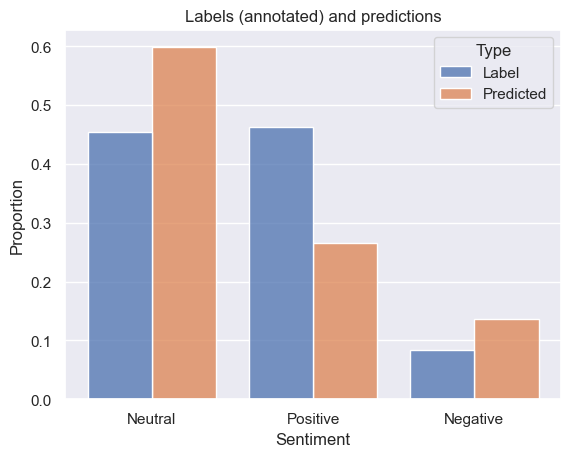

In [13]:
ax = sns.histplot(data=dist, x='sentiment', stat='proportion', hue='Type', multiple='dodge', shrink=.8,common_norm = False)
ax.set(title='Labels (annotated) and predictions', xlabel='Sentiment')
ax.yaxis.grid(True)
ax.xaxis.grid(False)

Finally we can get the metrics report. Notice that these results does not include the "Other" category which was the extra category defined for the annotation task. Hence there is an inherent bias in the results as we essentially excluded all tweets not relevant for the hypothesis in question.

Fraction of annotations excluding the "Other" category: 0.92


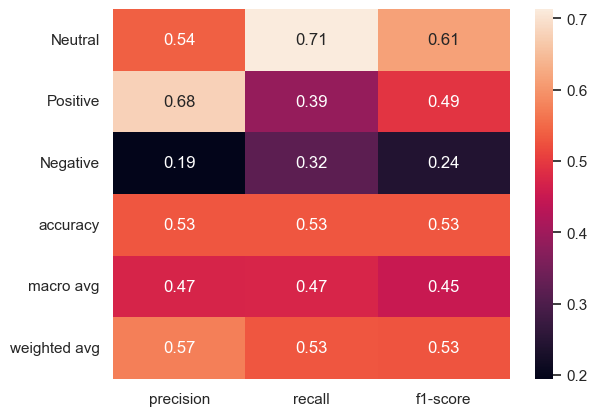

In [14]:
metrics_report = sklearn.metrics.classification_report(y_pred=predictions.sentiment, y_true=labels.sentiment, labels=labels.sentiment.unique(), output_dict=True)
metrics_report_df = pd.DataFrame(metrics_report).T
sns.heatmap(metrics_report_df.drop(columns=['support']), annot=True)
print(f'Fraction of annotations excluding the "Other" category: {predictions.tweet_id.count() / all_labels_including_ties.tweet_id.count():.2f}')

We can estimate how uncertain the models predictions are for the "Other" labels and the labels excluding the "Other" labels. The amount of uncertainty for a random variable $X$ is entropy which is defined as $H(X)=-\sum_{x\in X}p(x)\log p(x)$. We predict the uncertainty, or entropy, for each tweet and plot the distribution. We also find the mean entropy by averaging across tweets to compare how certain the model is for the two datasets, the ones including "Other" and those excluding it.

Mean entropy for "Other" labels: 0.66
Mean entropy for all labels except "Other": 0.64


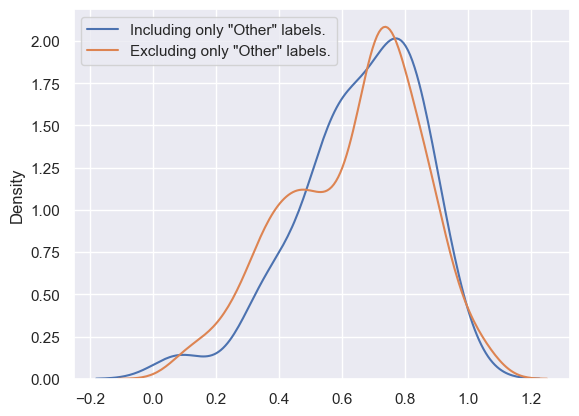

In [15]:
other_predictions = other_predictions_raw[['Negative', 'Neutral', 'Positive']]
predictions = predictions_raw[['Negative', 'Neutral', 'Positive']]

entropy_for_other_labels = -((other_predictions * np.log(other_predictions)).sum(axis=1))
entropy_for_rest = -((predictions * np.log(predictions)).sum(axis=1))

mean_entropy_for_other_labels = np.mean(entropy_for_other_labels)
mean_entropy_for_rest = np.mean(entropy_for_rest)

print(f'Mean entropy for "Other" labels: {mean_entropy_for_other_labels:.2f}\nMean entropy for all labels except "Other": {mean_entropy_for_rest:.2f}')
sns.kdeplot(entropy_for_other_labels)
sns.kdeplot(entropy_for_rest)
plt.legend(['Including only "Other" labels.', 'Excluding only "Other" labels.']); pass
